In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
pd.set_option('mode.chained_assignment', None)

!kaggle datasets download --force sudalairajkumar/novel-corona-virus-2019-dataset
!kaggle datasets download --force sudalairajkumar/covid19-in-italy

df = pd.read_csv('novel-corona-virus-2019-dataset/covid_19_data.csv')
dfIT = pd.read_csv('covid19-in-Italy/covid19_italy_region.csv')
dfIT['Date'] = pd.to_datetime(dfIT['Date']).dt.date
df['Date'] = pd.to_datetime(df['ObservationDate'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

  0%|                                                | 0.00/875k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 875k/875k [00:00<00:00, 10.4MB/s]
  0%|                                               | 0.00/96.3k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 96.3k/96.3k [00:00<00:00, 2.61MB/s]


In [3]:
def plot_new(df, key_region, regions, required_quantity, cumm_quantity, ax, date_cut = '2020-02-25', logy = True, kind = 'line', dropnull = True):
    for region in regions:
        dfRegion = df[df[key_region] == region]
        
        if date_cut is not None:
            dfRegion = dfRegion[dfRegion['Date'] > pd.to_datetime(date_cut)]
        
        if required_quantity not in df.columns:          
            dfRegion.loc[:, required_quantity] = dfRegion[cumm_quantity].diff()
            dfRegion[required_quantity].fillna(value = dfRegion[cumm_quantity], inplace = True)
            
            if dropnull:
                dfRegion[required_quantity] = dfRegion.apply(
                    lambda x: x[required_quantity] if x[required_quantity] >= 0
                                                    else np.nan, axis = 1)
                dfRegion.dropna(axis = 0, subset = [required_quantity], inplace = True)
        
        dfRegion.plot(x = 'Date', y = required_quantity, ax = ax, kind = kind, style = '-o')
    
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    if logy:
        ax.set_yscale('symlog')
    ax.yaxis.set_major_formatter(ScalarFormatter())

### New positive cases

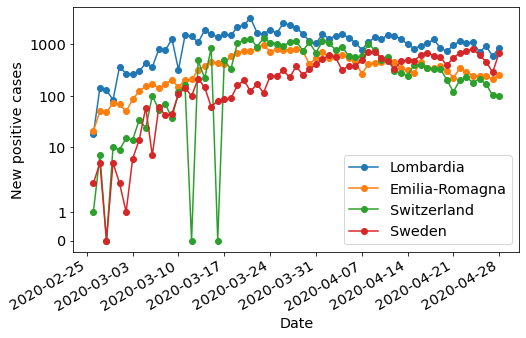

In [12]:
fig = plt.figure(figsize = (8,5))
ax = plt.gca()

provinces_IT = ['Lombardia', 'Emilia-Romagna']
plot_new(dfIT, key_region='RegionName', regions=provinces_IT, 
         required_quantity='NewPositiveCases', cumm_quantity=None, ax=ax)

countries = ['Switzerland', 'Sweden']
plot_new(df, key_region='Country/Region', regions=countries,
         required_quantity='NewPositiveCases', cumm_quantity='Confirmed', ax=ax)

ax.set_ylabel('New positive cases')
ax.legend(provinces_IT + countries)

plt.savefig('cases1.png', bbox_inches='tight')

### New reported deaths

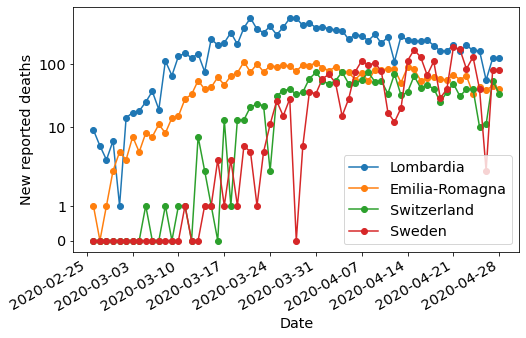

In [11]:
fig = plt.figure(figsize = (8,5))
ax = plt.gca()

provinces_IT = ['Lombardia', 'Emilia-Romagna']
plot_new(dfIT, key_region='RegionName', regions=provinces_IT, 
         required_quantity='NewDeaths', cumm_quantity='Deaths', ax=ax)

countries = ['Switzerland', 'Sweden']
plot_new(df, key_region='Country/Region', regions=countries,
         required_quantity='NewDeaths', cumm_quantity='Deaths', ax=ax)

# provinces_CN = ['Hubei']
# plot_new(df, key_region='Province/State', regions=provinces_CN, 
#          required_quantity='NewDeaths', cumm_quantity='Deaths', ax=ax)

ax.set_ylabel('New reported deaths')
ax.legend(provinces_IT + countries)

plt.savefig('deaths1.png', bbox_inches = 'tight')

### Taiwan and South Korea

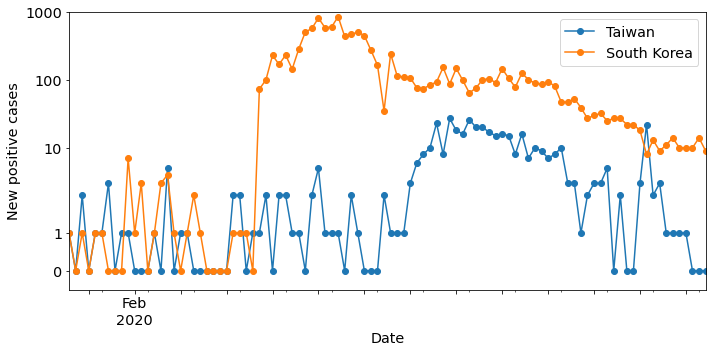

In [25]:
fig = plt.figure(figsize = (10,5))
ax = plt.gca()

countries = ['Taiwan', 'South Korea']
plot_new(df, key_region='Country/Region', regions=countries,
         required_quantity='NewPositiveCases', cumm_quantity='Confirmed', ax=ax, date_cut = None)
ax.set_ylabel('New positive cases')
ax.legend(countries)
ax.set_ylim([-0.5,1000])

plt.tight_layout()
plt.savefig('cases2.png')

### Evolution model with contact-tracing app

Evolution of infected app users $I_p$ and infected people $I_0$ who are not using the app. Fraction $p$ of population uses the app:

$d I_p/ d  t = p\beta I_p + p\beta I_0 - I_p/\tau_p$

$d I_0/ d  t = (1-p)\beta I_p + (1-p)\beta I_0 - I_0/\tau_0$

For $\mathbf{I} = (I_p, I_0)$, we write $d\mathbf{I}/d t = \mathrm{A} \mathbf{I}$ and diagonalize $\mathrm{A} = \mathrm{P}\mathrm{D}\mathrm{P}^{-1}$. The solution is then $\mathbf{I}(t) = \mathrm{P}\, exp(\mathrm{D} t)\,\mathrm{P^{-1}}\mathbf{I}(0)$

In [26]:
def plot_evolution(ax, p_values=[0.8], tau0 = 5, R0 = 2.5, taup = 1, t0 = 20, tmax = 100, N = 100):
    beta = R0/tau0
    t = np.linspace(0,t0,N)
    I = lambda t: np.exp((R0-1)*t/tau0)
    ax.semilogy(t, I(t), label = '_nolegend_')
    print(f'No. of infected at day {t0}: {I(t)[-1]}')
    
    for p in p_values:
        A = np.array([[p*beta - 1/taup, p*beta],[(1-p)*beta,(1-p)*beta - tau0**(-1)]])
        D, P = np.linalg.eig(A) 
        E = lambda t: P.dot(np.diag(np.exp(t*D))).dot(np.linalg.inv(P))

        t = np.linspace(t0,tmax,N)
        It0 = np.array([p*I(t0),(1-p)*I(t0)])
        I_after = [max(np.sum(E(t-t0).dot(It0)),1) for t in t]
        I_after = [np.sum(E(t-t0).dot(It0)) for t in t]
        ax.plot(t, I_after)
        
        
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected')
    ax.legend([f'p = {100*p}%' for p in p_values], title = 'App coverage')

No. of infected at day 20: 403.4287934927351


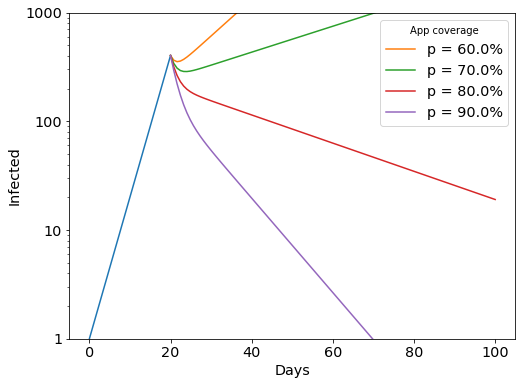

In [27]:
fig = plt.figure(figsize = (8,6))
ax = plt.axes()
plot_evolution(ax, [0.6, 0.7, 0.8, 0.9])
ax.set_ylim([1,1000])
plt.savefig('evolution_app.png')

In [35]:
def Reff(p, R0, tau0, taup):
    beta = R0/tau0
    A = np.array([[p*beta - 1/taup, p*beta],[(1-p)*beta,(1-p)*beta - tau0**(-1)]])
    D, P = np.linalg.eig(A)
    return np.max(D)*tau0 + 1
Reff = np.vectorize(Reff)

In [38]:
def plot_R_eff(ax, R0_values=[2.5, 2, 1.5, 1.1], tau0=5.0, taup=1.0):
    
    for R0 in R0_values:
        p = np.linspace(0,1,1000)
        plt.plot(100*p, Reff(p, R0, tau0, taup))
    
    plt.plot(100*p,np.ones(len(p)))
    ax.legend([f'$R_0 = {R0}$' for R0 in R0_values])
    ax.set_xlabel('$p [\%]$')
    ax.set_ylabel('$R_{e}$')

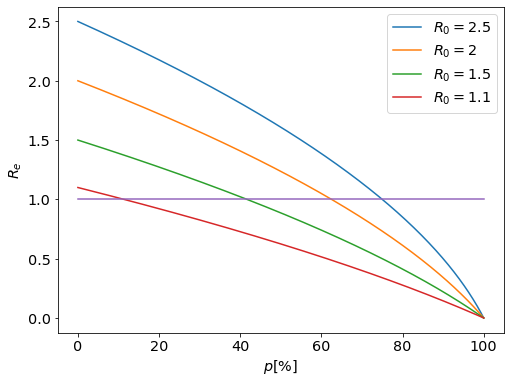

In [39]:
fig = plt.figure(figsize = (8,6))
ax = plt.axes()
plot_R_eff(ax)
plt.savefig('R_eff.png')